In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import pandas as pd
import subprocess
import itertools
import tfr_evaluate, util
import explain
import embed
import metrics
import quant_GIA
from test_to_bw_fast import read_model, get_config


In [5]:
background_model = 'dinuc'

In [8]:
out_dir = util.make_dir('sample_size')
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
run_path = '../paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5'
model = tf.keras.models.load_model(run_path)

In [9]:
run_name = [p for p in run_path.split('/') if 'run-' in p][0]
gia_add_dir = util.make_dir(os.path.join(out_dir, run_name))
C, X, Y = util.convert_tfr_to_np(testset, 3)

if background_model == 'dinuc':
    X_set = quant_GIA.select_set('all_threshold', C, X, Y)

In [13]:
cell_line = 'PC-3'
flank_scores = pd.read_csv('add_GIA_interaction/run-20211023_095131-w6okxt01/PC-3_..GATAA../dinuc/flanks.csv')
best_gata = flank_scores[flank_scores['cell line'] == cell_line].sort_values('mean difference').iloc[-1,0]
flank_scores = pd.read_csv('add_GIA_interaction/run-20211023_095131-w6okxt01/PC-3_..TGA.TCA../dinuc/flanks.csv')
best_ap1 = flank_scores[flank_scores['cell line'] == cell_line].sort_values('mean difference').iloc[-1,0]

In [18]:
dist = pd.read_csv('add_GIA_interaction/run-20211023_095131-w6okxt01/PC-3_..GATAA.._and_..TGA.TCA../1024_distance.csv')
best_dist = int(dist.sort_values('mean difference').iloc[-1,0].split('_')[1])
best_dist

1014

In [20]:
optimized_motifs = [[best_gata, 1024], [best_ap1, best_dist]]

In [26]:
all_N_dfs = []

Ns = [100, 1000, 5000, 10000]
for N in tqdm(Ns):
    gi = quant_GIA.GlobalImportance(model, targets)
    gi.set_null_model(background_model, base_sequence=X_set, num_sample=N)

    motifs_to_test = [ [(optimized_motifs[0][0], optimized_motifs[0][1])],
                            [(optimized_motifs[1][0], optimized_motifs[1][1])],
                            [(optimized_motifs[0][0], optimized_motifs[0][1]), (optimized_motifs[1][0], optimized_motifs[1][1])] ]
    interaction_test_dfs = []
    for motif_to_test in motifs_to_test:
        pattern_label = ' & '.join(['{} at {}'.format(m, str(p)) for m,p in motif_to_test])
        diff = gi.embed_predict_quant_effect(motif_to_test).mean(axis=1)
        df = pd.DataFrame({
                            'mean difference':np.array(diff).flatten(),
                            'cell line': np.tile(targets, diff.shape[0])})
        df['motif'] = pattern_label
        df['N'] = N
        interaction_test_dfs.append(df)
    
    all_N_dfs.append(pd.concat(interaction_test_dfs))
    

100%|██████████| 4/4 [03:10<00:00, 47.59s/it]


(array([0, 1, 2]),
 [Text(0, 0, 'AAGATAAAC at 1024'),
  Text(1, 0, 'GATGACTCATA at 1014'),
  Text(2, 0, 'AAGATAAAC at 1024 & GATGACTCATA at 1014')])

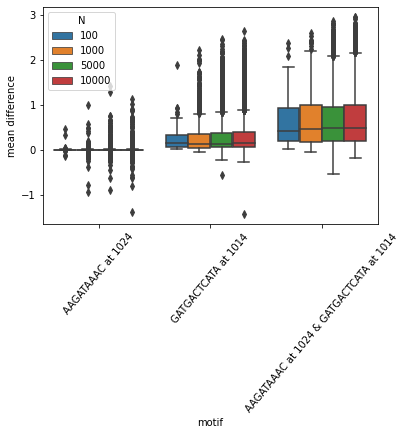

In [31]:
df = pd.concat(all_N_dfs)
sns.boxplot(data=df[df['cell line']==cell_line], x='motif', 
            y='mean difference', hue='N')
plt.xticks(rotation=50)